# VGG-11 on CIFAR-10 Dataset

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
from PIL import Image

## Settings

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
epochs = 20
batch_size = 128

## Transforms


In [3]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ]
    )
}

## Datasets


In [ ]:
cifar10_trainset = torchvision.datasets.CIFAR10(root = './data',train=True,download=True,transform=data_transforms["train"])
cifar10_testset = torchvision.datasets.CIFAR10(root = './data',train=False,download=True,transform=data_transforms["test"])

In [5]:
train_dset, valid_dset = random_split(cifar10_trainset, lengths=[45000, 5000])
train_loader = DataLoader(train_dset, batch_size=batch_size)
valid_loader = DataLoader(valid_dset, batch_size=batch_size)
test_loader = DataLoader(cifar10_testset, batch_size=batch_size)
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

## Visualize Some Images

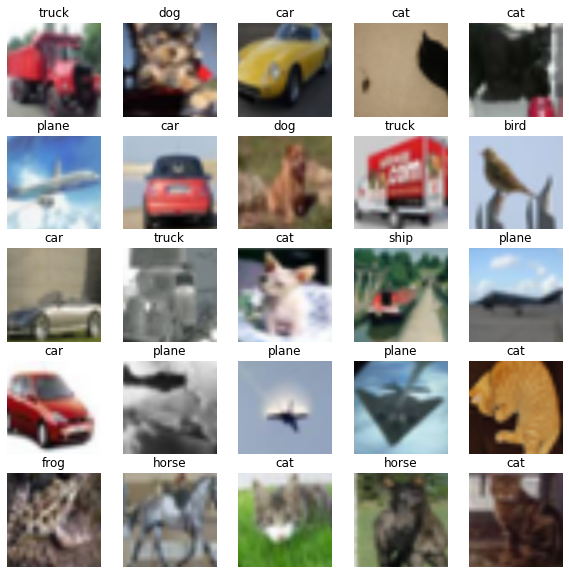

In [6]:
figure = plt.figure(figsize=(10,10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar10_trainset), size=(1,)).item()
    img, label = cifar10_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # Make img fall within this range [0:1]
    img = (img / 2)+0.5 
    # Permuting so that num of channels is the last argument
    plt.imshow(img.permute(1, 2, 0))
plt.show()

## Model

In [4]:
class VGG11(nn.Module):
  def __init__(self,conv_arch):
    super().__init__()
    self.conv_arch = conv_arch
    self.conv_blks = []
    self.in_channels = 3
    for (self.num_convs, self.out_channels) in self.conv_arch:
      self.conv_blks.append(self.vgg_block(self.num_convs, self.in_channels, self.out_channels))
      self.in_channels = self.out_channels
    self.net = nn.Sequential(*self.conv_blks,nn.Flatten(),
                             nn.Linear(self.out_channels*7*7,4096), nn.ReLU(), nn.Dropout(0.5),
                             nn.Linear(4096,4096), nn.ReLU(), nn.Dropout(0.5),
                             nn.Linear(4096,10) 
                            )
  def vgg_block(self,num_convs, in_channels, out_channels):
    layers = []
    for i in range(num_convs):
      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1))
      layers.append(nn.ReLU())
      in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)
  def forward(self,X):
    return self.net(X)

In [5]:
conv_arch = ((1,64),(1,128),(2,256),(2,512),(2,512))

In [9]:
net = VGG11(conv_arch)
net = net.to(device)

## Initialize Weights

In [ ]:
def init_weights(m):
  if type(m) == nn.Linear or type(m) == nn.Conv2d:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

## Train Loop

In [11]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float() / num_examples

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
start_time = time.time()
train_loss = []
for epoch in range(epochs):
    net = net.train()
    t_loss = []
    for batch_idx, (features, targets) in enumerate(train_loader):

        features, targets = features.to(device), targets.to(device)

        ### Forward pass
        logits = net(features)
        loss = F.cross_entropy(logits, targets)
       
        ### Backward pass (backpropagation)
        optimizer.zero_grad()
        loss.backward()

        ### Update model parameters
        optimizer.step()

        ### Batch-level logging
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )
    ### Epoch-level logging
    net = net.eval()
    train_acc = compute_accuracy(net, train_loader, device)
    valid_acc = compute_accuracy(net, valid_loader, device)
    print( 
        f"Training Accuracy: {train_acc * 100:.2f}% | "
        f"Validation Accuracy: {valid_acc * 100:.2f}%"
    )
    print(f"Time Elapsed: {(time.time() - start_time) / 60:.2f} min")

print(f"Total Training Time: {(time.time() - start_time) / 60:.2f} min")

## Evaluation

In [ ]:
test_acc = compute_accuracy(net, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")

## Save Trained Weights

In [14]:
torch.save(net.state_dict(), './vgg11_params.pth')